In [99]:
import os.path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange
from torchvision import transforms
from tqdm import tqdm

In [100]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super(DoubleConv, self).__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [101]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, self.bilinear)
        self.up2 = Up(512, 256 // factor, self.bilinear)
        self.up3 = Up(256, 128 // factor, self.bilinear)
        self.up4 = Up(128, 64, self.bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [102]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

target_transform = transforms.Compose([
    transforms.Lambda(lambda img: torch.from_numpy(np.array(img)))
])

class SemSegDS(torch.utils.data.Dataset):
    def __init__(self, root, split, transform, target_transform):
        from PIL import Image
        self.root = root
        self.path = os.path.join(self.root, 'sem-seg')
        self.split = split
        self.transform = transform
        self.target_transform = target_transform
        self.img_dir = os.path.join(os.path.expanduser(self.path), split, 'img')
        self.mask_dir = os.path.join(os.path.expanduser(self.path), split, 'label')
        self.imgs = [transform(Image.open(os.path.join(self.img_dir, f))) for f in sorted(os.listdir(self.img_dir))]
        self.masks = [target_transform(
            Image.open(os.path.join(self.mask_dir, f)).convert('L')
        ) for f in sorted(os.listdir(self.mask_dir))]

    def __getitem__(self, index):
        return self.imgs[index], self.masks[index]

    def __len__(self):
        return len(self.imgs)

train_ds = SemSegDS('~/data', 'train', transform, target_transform)
test_ds = SemSegDS('~/data', 'val', transform, target_transform)

torch.Size([96, 256])


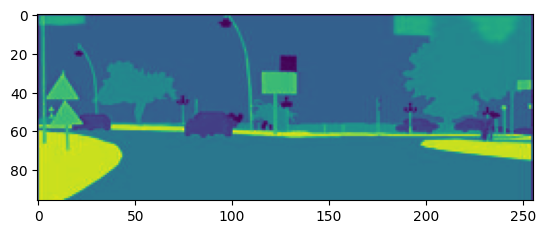

In [103]:
import matplotlib.pyplot as plt

for _, label in train_ds:
    print(label.shape)
    plt.imshow(label)
    break

In [104]:
from pandas import Series

ctx = Series()

ctx.batch_size = 8

train_dl = torch.utils.data.DataLoader(
    train_ds, batch_size=ctx.batch_size, shuffle=True
)
test_dl = torch.utils.data.DataLoader(
    test_ds, batch_size=ctx.batch_size, shuffle=False
)

In [109]:
ctx.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ctx.epochs = 500

model = UNet(n_channels=3, n_classes=256, bilinear=True).to(ctx.device)

criterion = nn.CrossEntropyLoss(ignore_index=255)  # Ignore void class (255)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

ctx.saved_w = 'unet.pt'

if os.path.isfile(ctx.saved_w):
    model.load_state_dict(
        torch.load(ctx.saved_w, weights_only=True)
    )

avg_loss: 1.551:   0%|          | 0/500 [00:44<?, ?it/s, 372 / 372 loss: 1.6350]

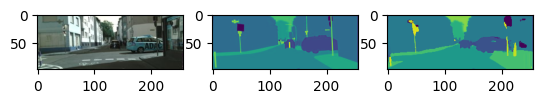

avg_loss: 1.548:   0%|          | 1/500 [01:28<6:11:36, 44.68s/it, 372 / 372 loss: 1.4654]

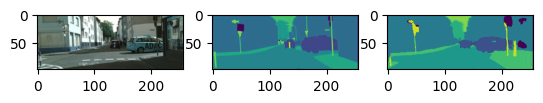

avg_loss: 1.548:   0%|          | 2/500 [02:13<6:09:50, 44.56s/it, 372 / 372 loss: 1.3962]

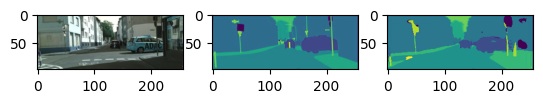

avg_loss: 1.545:   1%|          | 3/500 [02:57<6:08:35, 44.50s/it, 372 / 372 loss: 1.5580]

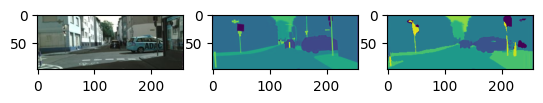

avg_loss: 1.543:   1%|          | 4/500 [03:42<6:07:38, 44.47s/it, 372 / 372 loss: 1.3770]

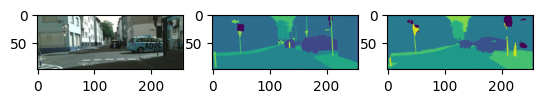

avg_loss: 1.541:   1%|          | 5/500 [04:26<6:06:18, 44.40s/it, 372 / 372 loss: 1.5554]

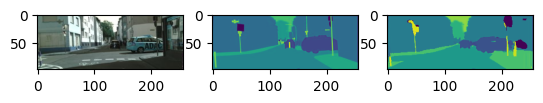

avg_loss: 1.540:   1%|          | 6/500 [05:10<6:05:16, 44.37s/it, 372 / 372 loss: 1.4715]

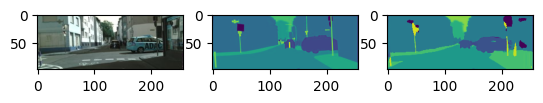

avg_loss: 1.543:   1%|▏         | 7/500 [05:55<6:04:25, 44.35s/it, 372 / 372 loss: 1.6620]

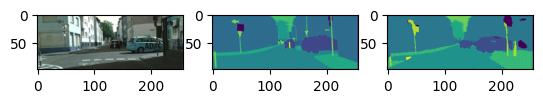

avg_loss: 1.537:   2%|▏         | 8/500 [06:39<6:03:36, 44.34s/it, 372 / 372 loss: 1.5958]

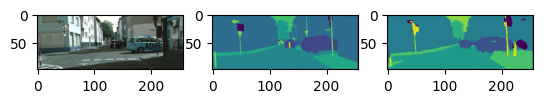

avg_loss: 1.534:   2%|▏         | 9/500 [07:23<6:02:51, 44.34s/it, 372 / 372 loss: 1.4567]

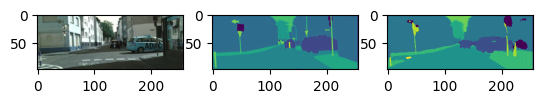

avg_loss: 1.532:   2%|▏         | 10/500 [08:08<6:02:08, 44.34s/it, 372 / 372 loss: 1.4184]

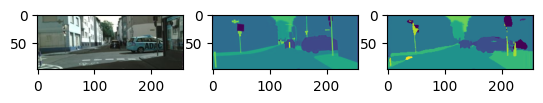

avg_loss: 1.531:   2%|▏         | 11/500 [08:52<6:01:20, 44.34s/it, 372 / 372 loss: 1.4947]

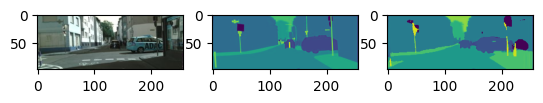

avg_loss: 1.529:   2%|▏         | 12/500 [09:36<6:00:37, 44.34s/it, 372 / 372 loss: 1.3816]

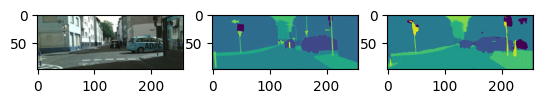

avg_loss: 1.526:   3%|▎         | 13/500 [10:21<6:00:15, 44.39s/it, 372 / 372 loss: 1.8410]

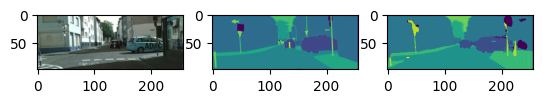

avg_loss: 1.526:   3%|▎         | 14/500 [11:05<5:59:26, 44.38s/it, 372 / 372 loss: 1.6398]

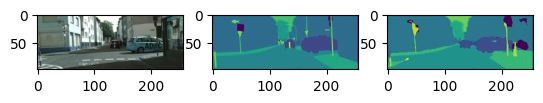

avg_loss: 1.524:   3%|▎         | 15/500 [11:49<5:58:47, 44.39s/it, 372 / 372 loss: 1.5299]

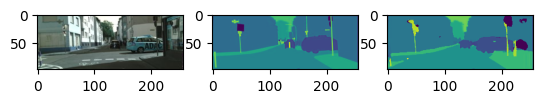

avg_loss: 1.524:   3%|▎         | 16/500 [11:53<5:59:30, 44.57s/it, 24 / 372 loss: 1.4260] 


KeyboardInterrupt: 

In [110]:
pbar = tqdm(range(1, 1 + ctx.epochs))

len_tr_dl = len(train_dl)

plt.ion()
for epoch in pbar:
    avg_loss = 0
    for idx, (images, targets) in enumerate(train_dl):
        images = images.to(ctx.device)
        targets = targets.to(ctx.device)

        optimizer.zero_grad()
        outputs = model(images)

        outputs = rearrange(outputs, 'b l h w -> (b h w) l')
        targets = rearrange(targets, 'b h w -> (b h w)')

        loss = criterion(outputs, targets.long())
        avg_loss += loss.item() / len_tr_dl
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_postfix_str(f'{idx + 1} / {len_tr_dl} loss: {loss.item():.4f}')
    pbar.set_description_str(f'avg_loss: {avg_loss:.3f}')
    fig, axes = plt.subplots(1, 3)
    for image, target in test_ds:
        axes[0].clear()
        axes[0].imshow(rearrange(image, 'c h w -> h w c'))
        torch.save(model.state_dict(), ctx.saved_w)
        model.eval()
        pred = model(image.to(ctx.device).unsqueeze(dim=0)).squeeze(dim=0)
        axes[1].clear()
        axes[1].imshow(target)
        pred = rearrange(pred, 'l h w -> h w l').argmax(dim=-1)
        axes[2].clear()
        axes[2].imshow(pred.cpu().detach().numpy())
        plt.pause(0.001)
        plt.show()
        model.train()
        break
